In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import string

#modules for n-gram model
#warnings ot surpressed
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K #backend to use outside metrics on n-gram model

#Bi-LSTM model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk import word_tokenize


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  

In [3]:
train = pd.read_csv('Train.csv')


In [4]:
from fastai import *
from fastai.text import *
from pathlib import Path
import torch

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

#new stuff
import keras
import codecs
import string
import re
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer


,sentiment,message,tweetid
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732


In [13]:
#preprocessing for the new stuff
#1 removing urls and changing to lower case.
#Substituting '@' with 'at' to track mentions
#changing hashtags into nor,mal words for tracking

#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))
stop_words = set((list(stop)+list(stop2)))
#lemmetize
def lemm(word):
    lemme = WordNetLemmatizer()
    result = lemme.lemmatize(word)
    return result

#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop_words and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

def clean_text(text):
    text2 = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)
    no_punct = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ",text2)
    text_men = re.sub(r"@", "at", no_punct)
    text_nonum = re.sub(r'\d+', '', text_men)
    text_cleaned = "".join([char.lower() for char in text_nonum if char not in string.punctuation])    
    return text_cleaned


train['cleaned'] = train['message'].apply(clean_text)
train['tokenized'] = train['cleaned'].apply(tokenizer_2)

In [14]:
from nltk.tokenize import RegexpTokenizer

tokReg = RegexpTokenizer(r'\w+')

train["reg"] = train["cleaned"].apply(tokReg.tokenize)
train.head()

,sentiment,message,tweetid,cleaned,tokenized,reg
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[like, lack, evidence, anthropogenic, global, ...","[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt atrawstory researchers say we have three y...,"[rt, atrawstory, researcher, say, year, act, c...","[rt, atrawstory, researchers, say, we, have, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in ...,"[todayinmaker, wired, pivotal, year, war, clim...","[todayinmaker, wired, was, a, pivotal, year, i..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt atsoynoviodetodas its and a racist sexist...,"[rt, atsoynoviodetodas, racist, sexist, climat...","[rt, atsoynoviodetodas, its, and, a, racist, s..."


In [49]:
#Creating padded word sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in train["tokenized"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in train["tokenized"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

173449 words total, with a vocabulary size of 21357
Max sentence length is 23


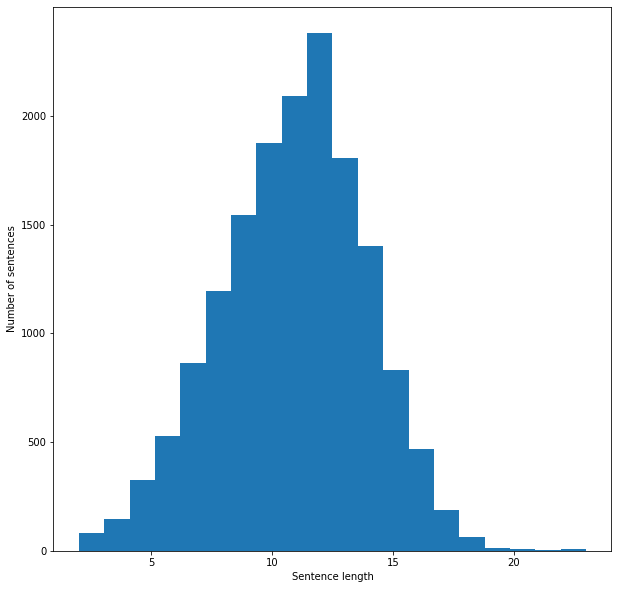

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, bins=20, )
plt.show()

In [10]:
import gensim

embedding_path = "glove.twitter.27B.50d.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
word2vec = get_word2vec(embedding_path)

In [11]:
def get_average_word2vec(tokens_list, vector, generate_missing=True, k=50):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = train['tokenized'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [26]:
embeddings = get_word2vec_embeddings(word2vec, train)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, train['sentiment'].values, 
                                                                                        test_size=0.2, random_state=32)

In [21]:
dfx_train, dfx_test, dfy_train, dfy_test = train_test_split(train, train['sentiment'], 
                                                                                        test_size=0.2, random_state=32)

In [23]:
data_lm = TextLMDataBunch.from_df(train_df=dfx_train, valid_df=dfx_test, path="", label_cols='sentiment', text_cols='tokenized')
learn = language_model_learner(data_lm, drop_mult=0.1, arch=AWD_LSTM)
learn.fit_one_cycle(1, 1e-2)
learn.save_encoder('trial_enc')
data_clas = TextClasDataBunch.from_df(path="", train_df=dfx_train, valid_df=dfx_test, label_cols='sentiment', text_cols='tokenized', vocab=data_lm.train_ds.vocab, bs=16)
learn = text_classifier_learner(data_clas,drop_mult=0.1, arch=AWD_LSTM)

epoch,train_loss,valid_loss,accuracy,time
0,1.443258,1.241126,0.818074,08:39


In [24]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.134625,1.395458,0.546144,1:18:05
1,0.912327,1.275614,0.423198,1:10:15
2,0.786686,0.784780,0.693426,1:12:19
3,0.681477,0.729540,0.718394,1:09:11
4,0.593967,0.720859,0.715234,1:11:45
5,0.449679,0.756782,0.720291,1:11:46
6,0.356361,0.858484,0.713970,1:08:44
7,0.257421,0.933400,0.713654,1:08:06
8,0.210610,1.023135,0.706700,1:12:46


KeyboardInterrupt: 

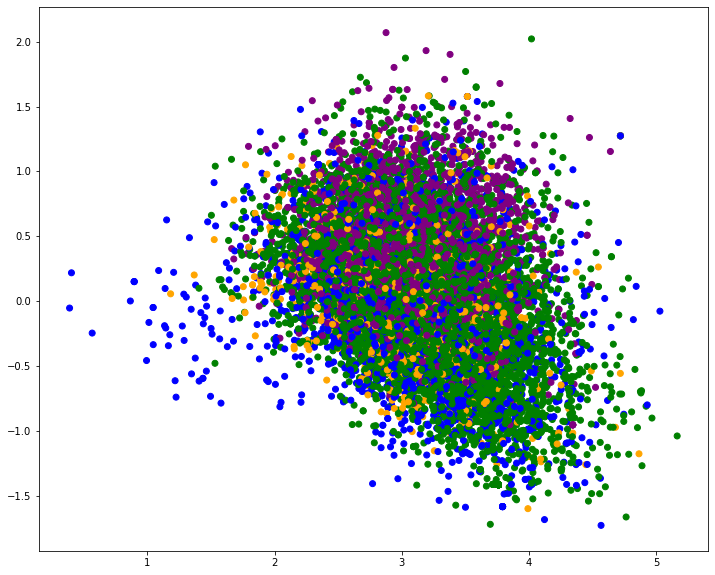

In [27]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
fig = plt.figure(figsize = (12,10))
lsa2 = TruncatedSVD(n_components = 2)
lsa2.fit(embeddings)
scores_train = lsa2.transform(embeddings)
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['orange','blue','green', 'purple']
plt.scatter(scores_train[:,0], scores_train[:,1], c=train['sentiment'].values, cmap=matplotlib.colors.ListedColormap(colors))


plt.show()

In [38]:
#using Gensim library to create the topic modelling and also to give us tasty visualizations at the end
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
#creating our corpus of words to use in our topic modelling algorithm 2
#rememebr to check tghe cleaning done to the text and the way inh wich they are tokenized as this will determine the corpus we create here
dictionary = Dictionary(train['tokenized'])
dictionary.compactify()
dictionary.filter_extremes(no_below =2, no_above=5,keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in train['tokenized']]

#serializing corpus
MmCorpus.serialize('TweetCorpNew.mm', corpus)

#save dictionary
dictionary.save('TweetCorpNew.dict')

In [40]:
saver2 = pd.DataFrame(data = (train[['sentiment', 'cleaned']]), copy = True)
saver2.to_csv('saver2.csv', header = False, index = False)

path = './'
data_lm = TextLMDataBunch.from_csv(path , 'saver2.csv', min_freq=1)
data_lm.save()
data_lm.show_batch()

idx,text
0,climate change nat l securities regulator farm xxbos rt atdemocracynow human induced climate change is making extreme weather events stronger and more frequent more costly more deadly https xxbos gore warns of dangers of climate change at atlanta meeting d c is one xxbos rt atgrimezsz denying climate change is not a luxury humanity can afford trump is old amp rich he will never have worry abt foo xxbos by
1,xxbos rt atguardiancities with climate change rising temperatures will affect cities around the world tell us how is it an issue where you liv xxbos rt atnatgeochannel watch beforetheflood right here as atleodicaprio travels the world to tackle climate change htt xxbos rt atabcworldnews sec of state rex tillerson used alias account in some climate change emails during tenure at exxon prosecutors sa xxbos atjamesgrace i m hearing rumours that
2,xxbos is this the climate change stat that will wake people up xxbos rt atdylanhbroady inner city neighborhoods have become war zones but global warming is our biggest issue no jobs but transgender issue xxbos atbigjimsports what s laughable to me is people who ignore scientists who at least question climate change narratives xxbos rt atthedailybeast stephen colbert sums up trumps climate change policy f ck the planet xxbos rt
3,climate change impredecibilidad futura xxbos rt atanonypress was the year that the united states elected a man who believes that global warming is a chinese conspiracy xxbos rt atwired the hurricane is a naturally occurring hazard that is exacerbated by climate change xxbos atpaullysteaks so we should just shit all over the earth concensus is enough to justify any climate change action xxbos atfoxnews hey where is the global warming
4,xxbos u s epa chief unconvinced on co link to global warming xxbos atrangersfan atnytimes pollution is not the same as global warming xxbos rt atdanrather the so called house science committee tweets out breitbart article denying accepted science of climate change \n \n https xxbos rt atscientistseu meh why believe nasa \n donald trumps pick for cia director refuses to accept nasa findings on climate change https


In [41]:
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult =0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


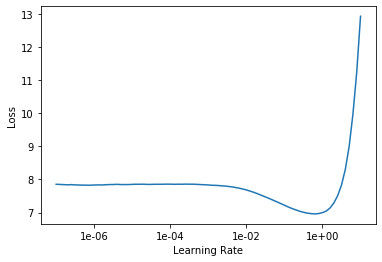

In [43]:
learner.lr_find(start_lr=1e-8,end_lr=1e2)
learner.recorder.plot()

In [44]:
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, 
                               drop_mult=0.5)
learner.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.357960,6.556993,0.161687,04:32


In [ ]:
learner.unfreeze()
learner.fit_one_cycle(cyc_len=2, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.443979,4.710593,0.323039,09:37


In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

In [35]:
X_train_word2vec

[array([ 1.940399e-01,  2.393904e-01, -2.517707e-01, -8.991221e-02,  4.526403e-01,  1.966107e-01,  4.846947e-01,
         2.028919e-01,  3.304731e-01, -2.091896e-01,  1.293758e-01, -1.789093e-01, -2.803964e+00,  1.283342e-01,
         4.191144e-01, -3.300574e-02,  6.361521e-02,  2.693414e-01,  3.369574e-01, -2.780521e-01, -7.916507e-02,
        -1.535942e-01, -2.654711e-01, -2.533921e-02, -1.830243e-02,  5.992850e-01, -4.498857e-02,  6.912133e-02,
        -2.284244e-01,  7.553329e-02, -9.865714e-04, -4.667624e-01,  1.064601e-01, -1.794644e-01,  7.649936e-01,
        -1.166614e-01, -2.563816e-01,  3.040864e-01,  1.973169e-01, -3.318995e-01, -7.736721e-01, -1.505011e-01,
         2.136924e-01,  1.391324e-01,  1.376058e-01,  1.818704e-01,  2.223138e-01,  1.748489e-01,  1.006336e-02,
         1.826614e-01]),
 array([ 0.381512,  0.235979, -0.5538  , -0.077922,  0.331033,  0.16402 ,  0.272665, -0.273868,  0.189378, -0.314581,
        -0.145069, -0.291754, -3.14183 ,  0.165841,  0.197677, -0.

In [ ]:
LogisticRegression(multi_class=))

In [36]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {"CatBoost" : CatBoostClassifier(depth=9,
                                              bootstrap_type= 'Bayesian', 
                                              loss_function = 'MultiClass', 
                                              iterations=80, learning_rate=0.4, 
                                              l2_leaf_reg=26),
              'svm': LogisticRegression(solver = 'newton-cg',
                                        multi_class = 'ovr',
                                        n_jobs = -1,
                                        random_state = 32),
              "SVC": SVC(max_iter = 100, kernel =  'linear' ),
              'Random Forest': RandomForestClassifier(random_state=32),
              'K Nearest Neighbor': KNeighborsClassifier()}



#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train_word2vec, y_train_word2vec)
        y_pred = v.predict(X_test_word2vec)
        ac_score_list.append(accuracy_score(y_test_word2vec, y_pred))
        p_score_list.append(precision_score(y_test_word2vec, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test_word2vec, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test_word2vec, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

0:	learn: 1.2613134	total: 370ms	remaining: 29.2s
1:	learn: 1.1796265	total: 768ms	remaining: 30s
2:	learn: 1.1139011	total: 1.14s	remaining: 29.2s
3:	learn: 1.0751831	total: 1.52s	remaining: 28.9s
4:	learn: 1.0349901	total: 1.91s	remaining: 28.6s
5:	learn: 1.0070655	total: 2.26s	remaining: 27.9s
6:	learn: 0.9843571	total: 2.65s	remaining: 27.7s
7:	learn: 0.9662584	total: 3.04s	remaining: 27.3s
8:	learn: 0.9491598	total: 3.4s	remaining: 26.8s
9:	learn: 0.9334120	total: 3.76s	remaining: 26.4s
10:	learn: 0.9214238	total: 4.11s	remaining: 25.8s
11:	learn: 0.9098165	total: 4.46s	remaining: 25.3s
12:	learn: 0.8993558	total: 4.82s	remaining: 24.8s
13:	learn: 0.8897154	total: 5.17s	remaining: 24.4s
14:	learn: 0.8808832	total: 5.52s	remaining: 23.9s
15:	learn: 0.8705511	total: 5.88s	remaining: 23.5s
16:	learn: 0.8632152	total: 6.23s	remaining: 23.1s
17:	learn: 0.8549395	total: 6.59s	remaining: 22.7s
18:	learn: 0.8485552	total: 6.94s	remaining: 22.3s
19:	learn: 0.8418056	total: 7.29s	remaining:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,model_name,accuracy_score,precision_score,recall_score,f1_score
4,K Nearest Neighbor,0.647282,0.562404,0.493043,0.516058
0,CatBoost,0.667826,0.669541,0.47131,0.499332
3,Random Forest,0.676991,0.770519,0.460326,0.4929
1,svm,0.619153,0.575924,0.400398,0.408561
2,SVC,0.405499,0.333844,0.308808,0.26781


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
def vectorizer(tokens):
    global vect
    emb = vect.fit_transform(tokens)
    return emb
x = train['cleaned'].to_list()
y = train['sentiment'].to_list()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [324]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

array([[    0,  6222,    18, ...,   444,     1,     1],
       [    0,     0,     0, ...,  1251,     5,     6],
       [    0,     0,     4, ...,     1,     1,   663],
       ...,
       [13868,     4, 13869, ...,  2435,     1,     1],
       [  318,     1,     1, ...,  3359,     1,  6202],
       [    0,     0,     0, ...,  4301,     1, 13870]])

In [9]:
tf_vect = TfidfVectorizer()
xtrian_vect_tfidf = tf_vect.fit_transform(x_train)
xtest_vect_tfidf = tf_vect.transform(x_test)

In [ ]:
#Embeddings with 

In [153]:
embeddings_dict = {}


with open("glove.twitter.27B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:])
        embeddings_dict[word] = vector


embedding_path = "glove.twitter.27B.50d.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
w2v = get_word2vec(embedding_path)

In [ ]:
'''
class MeanVect(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
    # pass a word list
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in (X)
        ])
'''

In [ ]:
train.pop('tweetid')
train.pop('message')
#trial. DONT USE ON LIST!!
t_vector = TfidfVectorizer(ngram_range=(1, 2),
                            
                           strip_accents = 'unicode',
                           decode_error = 'replace',
                           analyzer = 'word',
                           min_df = .1, 
                           max_df = .50,
                           stop_words = stop)

token_vect=  t_vector.fit_transform(train['tokens'].values)
hash_vect = t_vector.fit_transform(train['tags'].values)

In [84]:
train['message'] = train['message'].apply(lambda x: ' '.join(x.lower() for x in x.split()))


In [6]:
#Number of samples
sample_tot = len(train.index.values)
print(sample_tot)

15819


In [7]:
#Number of classes
sent_val = set(train['sentiment'].values)
sent_count = len(set(train['sentiment'].values))
print(sent_val)
print(sent_count)

{0, 1, 2, -1}
4


In [8]:
#number of samples per class
for i in set(train['sentiment'].values):
    count = 0
    for x in train['sentiment']:
        if x == i:
            count+=1
    print("Sentiment "+ str(i)+' '+ "observations :"+ str(count))

Sentiment 0 observations :2353
Sentiment 1 observations :8530
Sentiment 2 observations :3640
Sentiment -1 observations :1296


In [9]:
#median words per tweet
def word_count(text):
    num_words = [len(s.split()) for s in text]
    return np.median(num_words)
words = word_count(train['message'])
print(words)

18.0


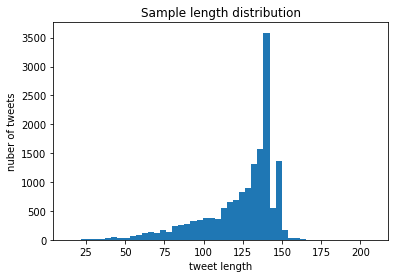

In [10]:
#distr. tweet lengths
def sample_plotter(text2):
    plt.hist([len(s) for s in text2], 50)
    plt.xlabel('tweet length')
    plt.ylabel('nuber of tweets')
    plt.title('Sample length distribution')
    plt.show()

sample_plotter(train['message'])

In [11]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [12]:
#word sample ratios
word_sample_ratio = sample_tot/words
print(round(word_sample_ratio, 0))

879.0


In [325]:
#sentiment prep
def adder(text):
    num = int(text)
    num = num + 1
    return num
train['sentiment'] = train['sentiment'].apply(adder)
train['sentiment'] = train['sentiment'].replace(3, 2)
train['sentiment']
y = train['sentiment'].values

In [299]:
#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))

In [18]:
X = train.iloc[:, 1].values
y = train.iloc[:, 0].values

In [ ]:
embeddings_index = {}
f = open(os.path.join('../glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [326]:
#test and train
from sklearn.model_selection import train_test_split
X, validation_x, Y, validation_y = train_test_split(x, y, test_size=0.30, shuffle = True, random_state=32)
train_text, test_text, train_val, test_val = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=32)



In [346]:
embeddings_dict = {}


with open("glove.twitter.27B.100d.txt", 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:])
        embeddings_dict[word] = vector


embedding_path = "glove.twitter.27B.100d.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
w2v = get_word2vec(embedding_path)

KeyboardInterrupt: 

In [348]:
embeddings_index = {}
with open("glove.twitter.27B.100d.txt", 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [350]:
word_index = token.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13870 unique tokens.


In [356]:
num_words = min(20000, len(word_index)) + 1
em_mat = np.zeros((num_words, 100))
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        em_mat[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        em_mat[i] = np.random.randn(100)

In [320]:
#tokenizing into uni+bi-grams and vectorizing
from sklearn.feature_extraction.text import TfidfTransformer


t_vector = TfidfVectorizer(ngram_range=(1, 2),
                            
                           strip_accents = 'unicode',
                           decode_error = 'replace',
                           analyzer = 'word',
                           min_df = .1, 
                           max_df = .50,
                           stop_words = stop)
x_train = t_vector.fit_transform(train_text)
x_val = t_vector.transform(test_text)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [327]:
#Selecting top 20 000 Features for n-gram model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

b_vect = SelectKBest(f_classif, k = min(20000, train_text.shape[1]))
b_vect.fit(train_text, train_val)
train_text = b_vect.transform(train_text).astype('float32')
x_train = train_text
test_text = b_vect.transform(test_text).astype('float32')
x_val = test_text

In [328]:
x_train

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 3.000e+00, 1.460e+02,
        1.000e+00],
       [4.000e+00, 7.710e+02, 7.710e+02, ..., 7.710e+02, 7.710e+02,
        2.744e+03],
       [1.000e+00, 1.000e+00, 3.100e+01, ..., 1.000e+00, 1.300e+01,
        2.467e+03],
       ...,
       [1.000e+00, 4.880e+02, 1.000e+00, ..., 1.000e+00, 4.460e+02,
        1.000e+00],
       [2.524e+03, 3.566e+03, 1.000e+00, ..., 1.000e+00, 3.630e+02,
        4.789e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.000e+00,
        3.000e+00]], dtype=float32)

In [329]:
x_val

array([[4.000e+00, 7.070e+02, 1.570e+02, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [0.000e+00, 0.000e+00, 4.000e+00, ..., 1.000e+00, 3.200e+01,
        7.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        3.150e+02],
       ...,
       [1.000e+00, 1.800e+01, 1.000e+00, ..., 2.000e+00, 3.000e+00,
        4.275e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 3.000e+00,
        1.000e+00],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.000e+00, 4.845e+03,
        1.000e+00]], dtype=float32)

In [377]:
#building  multilayer perceptron
#not optimized
from keras.layers import Embedding, Bidirectional, LSTM
from keras.initializers import Constant
drop_rate = 0.2
#layers = 2
clasif = models.Sequential()
clasif.add(Embedding(num_words,
                     100,
                     embeddings_initializer =Constant(em_mat),
                     input_length = 18,
                     trainable=True))
clasif.add(Dropout(rate = drop_rate, input_shape = x_train.shape[1:]))
#clasif.add(Bidirectional(LSTM(64, return_sequences = True)))
#clasif.add(Bidirectional(LSTM(32)))
clasif.add(Dropout(rate = 0.1))
clasif.add(Dense(units = 3,activation = 'softmax'))


#for lvl in range(layers - 1):
#    clasif.add(Dense(units = 3, activation = 'relu'))
#    clasif.add(Dropout(rate = 0.1))
#clasif.add(Dense(units = 3,activation = 'softmax'))

In [378]:
#N-gram model training and validation. Haven't used balance library
#Metrics calc for metrics not available in Keras. Funcs from Stackoverflow

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


optimizer = Adam(lr = 1e-3)
clasif.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc', f1_m, precision_m, recall_m])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
history = clasif.fit(
            x_train,
            train_val,
            epochs=1000,
            batch_size = 128,
            callbacks=callbacks,
            validation_data=(x_val, test_val),
            verbose=2,  # Logs once per epoch.
            )
history = history.history
print('Validation accuracy: {acc}, loss: {loss}, f1_score: {f1}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1], f1 = history['val_f1_m']))

ValueError: Error when checking target: expected dense_13 to have 3 dimensions, but got array with shape (8858, 1)

In [10]:
from imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
pipeline = make_pipeline(RandomOverSampler(random_state=32), CatBoostClassifier(depth=9, 
                                                                                bootstrap_type= 'Bayesian', 
                                                                                loss_function = 'MultiClass', 
                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))
pipeline.fit(xtrian_vect_tfidf,
            y_train)


0:	learn: 1.2839985	total: 3.14s	remaining: 4m 8s
1:	learn: 1.2223510	total: 6.19s	remaining: 4m 1s
2:	learn: 1.1843447	total: 9.21s	remaining: 3m 56s
3:	learn: 1.1622833	total: 12.4s	remaining: 3m 54s
4:	learn: 1.1377032	total: 15.5s	remaining: 3m 52s
5:	learn: 1.1208839	total: 18.6s	remaining: 3m 49s
6:	learn: 1.1049771	total: 21.8s	remaining: 3m 47s
7:	learn: 1.0922193	total: 24.9s	remaining: 3m 44s
8:	learn: 1.0781390	total: 28.1s	remaining: 3m 41s
9:	learn: 1.0666025	total: 31.2s	remaining: 3m 38s
10:	learn: 1.0540206	total: 34.4s	remaining: 3m 35s
11:	learn: 1.0471145	total: 37.6s	remaining: 3m 33s
12:	learn: 1.0374707	total: 40.8s	remaining: 3m 30s
13:	learn: 1.0294899	total: 44s	remaining: 3m 27s
14:	learn: 1.0201484	total: 47.3s	remaining: 3m 24s
15:	learn: 1.0130479	total: 50.5s	remaining: 3m 21s
16:	learn: 1.0046127	total: 53.7s	remaining: 3m 18s
17:	learn: 0.9996053	total: 56.8s	remaining: 3m 15s
18:	learn: 0.9951508	total: 60s	remaining: 3m 12s
19:	learn: 0.9897960	total: 

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=32)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001E4433D60C8>)])

In [11]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
y_pred2 = pipeline.predict(xtest_vect_tfidf )
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2, average = 'macro'))
print(recall_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='macro'))

0.6077749683944375
0.548017256837261
0.6134206157404882
0.5595726860510644


In [12]:
y_pred = clasif.predict_classes(validation_x)
score = f1_score(validation_y, y_pred, average='macro')
score

NameError: name 'clasif' is not defined

In [58]:
train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


In [4]:
'''
Lowercaase, remove punct and numbers
'''
import string


def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace


'\ntrain[\'cleaned\'] = train[\'message\'].str.split()\nfor text in train[\'message\']:\n    text_nonum = re.sub(r\'\\d+\', \'\', text)\n    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) \n    text_no_doublespace = re.sub(\'\\s+\', \' \', text_nopunct).strip()\n    train[\'message\'] = text_no_doublespace\n'

In [59]:
train['message'] = train['message'].apply(clean_text)

In [60]:
def counter(text):
    # remove numbers
    count = len(text)
    return count
train['count'] = train['message'].apply(counter)
train.pop('tweetid')
train.head()

,sentiment,message,count
0,1,polyscimajor epa chief doesnt think carbon dio...,128
1,1,its not like we lack evidence of anthropogenic...,61
2,2,rt rawstory researchers say we have three year...,125
3,1,todayinmaker wired was a pivotal year in the w...,83
4,1,rt soynoviodetodas its and a racist sexist cli...,109


In [ ]:
from nltk import word_tokenize
def tokenizer(text3):
    tokenized = word_tokenize(text3)
    return tokenized

In [ ]:
train['tokenized'] = train["message"].apply(tokenizer)

In [ ]:
train.head()

In [61]:
texts = train['message']

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95,
                                  stop_words = stop2)

x_train = tfidf_vectorizer.fit_transform(texts) #features

In [62]:
x_train.shape

(15819, 22505)

In [63]:
from sklearn.decomposition import TruncatedSVD 
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

x_train = lsa.fit_transform(x_train)
x_train.shape

(15819, 100)

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = stop2)
tfidf = vectorizer.fit_transform(text4)
return tfidf
'''

In [ ]:
def cleaner_text(text2):
    tweet = [w for w in text2 if w not in list(stop2)]
    return tweet

In [ ]:
train['tokey'] = train['tokenized'].apply(cleaner_text)

In [ ]:
train.head()

In [ ]:
train['tokey2'] = train['tokenized'].apply(vect_funct)

In [ ]:
train.head()

In [64]:
y_train = train['sentiment'].values

In [65]:
from sklearn.model_selection import train_test_split
X_trainer, X_tester, y_trainer, y_tester = train_test_split(x_train, y_train, test_size=0.20, shuffle = True, random_state=32)

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize, MaxAbsScaler

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

In [77]:
scaler = MaxAbsScaler()
x_scaled = scaler.fit_transform(X_train_word2vec)
x_test_scaled = scaler.fit_transform(X_test_word2vec)

In [80]:
from sklearn.linear_model import LogisticRegression


In [82]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {"CatBoost" : CatBoostClassifier(depth=9,
                                              bootstrap_type= 'Bayesian', 
                                              loss_function = 'MultiClass', 
                                              iterations=80, learning_rate=0.4, 
                                              l2_leaf_reg=26),
              "LogR" : LogisticRegression(C=30.0, solver='newton-cg', 
                         multi_class='multinomial', random_state=32),
              "SVC": SVC(max_iter = 100, kernel =  'linear' ),
              'Random Forest': RandomForestClassifier(random_state=32),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train_word2vec, y_train_word2vec)
        y_pred = v.predict(X_test_word2vec)
        ac_score_list.append(accuracy_score(y_test_word2vec, y_pred))
        p_score_list.append(precision_score(y_test_word2vec, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test_word2vec, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test_word2vec, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

0:	learn: 1.2613134	total: 363ms	remaining: 28.7s
1:	learn: 1.1796265	total: 723ms	remaining: 28.2s
2:	learn: 1.1139011	total: 1.11s	remaining: 28.5s
3:	learn: 1.0751831	total: 1.47s	remaining: 27.9s
4:	learn: 1.0349901	total: 1.86s	remaining: 28s
5:	learn: 1.0070655	total: 2.25s	remaining: 27.7s
6:	learn: 0.9843571	total: 2.62s	remaining: 27.3s
7:	learn: 0.9662584	total: 2.99s	remaining: 26.9s
8:	learn: 0.9491598	total: 3.35s	remaining: 26.4s
9:	learn: 0.9334120	total: 3.71s	remaining: 25.9s
10:	learn: 0.9214238	total: 4.07s	remaining: 25.5s
11:	learn: 0.9098165	total: 4.44s	remaining: 25.1s
12:	learn: 0.8993558	total: 4.8s	remaining: 24.7s
13:	learn: 0.8897154	total: 5.18s	remaining: 24.4s
14:	learn: 0.8808832	total: 5.57s	remaining: 24.2s
15:	learn: 0.8705511	total: 5.96s	remaining: 23.8s
16:	learn: 0.8632152	total: 6.31s	remaining: 23.4s
17:	learn: 0.8549395	total: 6.66s	remaining: 22.9s
18:	learn: 0.8485552	total: 7.01s	remaining: 22.5s
19:	learn: 0.8418056	total: 7.37s	remaining:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,model_name,accuracy_score,precision_score,recall_score,f1_score
4,K Nearest Neighbor,0.647282,0.562404,0.493043,0.516058
0,CatBoost,0.667826,0.669541,0.47131,0.499332
3,Random Forest,0.676991,0.770519,0.460326,0.4929
1,LogR,0.620417,0.549231,0.416393,0.432487
2,SVC,0.405499,0.333844,0.308808,0.26781


In [70]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [35]:
from imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import make_pipeline
pipeline = make_pipeline(SMOTE(random_state=32), CatBoostClassifier(depth=9, 
                                                                                bootstrap_type= 'Bayesian', 
                                                                                loss_function = 'MultiClass', 
                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))
pipeline.fit(xtrian_vect_tfidf, y_train)

0:	learn: 1.2442348	total: 7.61s	remaining: 10m 1s
1:	learn: 1.1677819	total: 14.9s	remaining: 9m 40s
2:	learn: 1.1159261	total: 22.1s	remaining: 9m 27s
3:	learn: 1.0831057	total: 29.3s	remaining: 9m 17s
4:	learn: 1.0543984	total: 36.8s	remaining: 9m 12s
5:	learn: 1.0320044	total: 44.3s	remaining: 9m 5s
6:	learn: 1.0146599	total: 51.6s	remaining: 8m 58s
7:	learn: 0.9952323	total: 59.2s	remaining: 8m 52s
8:	learn: 0.9762845	total: 1m 6s	remaining: 8m 44s
9:	learn: 0.9614952	total: 1m 13s	remaining: 8m 36s
10:	learn: 0.9471608	total: 1m 21s	remaining: 8m 28s
11:	learn: 0.9328306	total: 1m 28s	remaining: 8m 20s
12:	learn: 0.9187866	total: 1m 35s	remaining: 8m 11s
13:	learn: 0.9080497	total: 1m 42s	remaining: 8m 4s
14:	learn: 0.8998955	total: 1m 50s	remaining: 7m 57s
15:	learn: 0.8920224	total: 1m 57s	remaining: 7m 49s
16:	learn: 0.8837223	total: 2m 4s	remaining: 7m 42s
17:	learn: 0.8734523	total: 2m 12s	remaining: 7m 35s
18:	learn: 0.8684454	total: 2m 20s	remaining: 7m 29s
19:	learn: 0.86

Pipeline(steps=[('smote', SMOTE(random_state=32)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000001E443405448>)])

In [43]:
y_pred2 = pipeline.predict(x_test_scaled)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2, average = 'macro'))
print(recall_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='macro'))

0.6125158027812895
0.5493290938354043
0.5740078348640866
0.5507693422949439


In [37]:
#RandomOverSampler
y_pred2 = pipeline.predict(x_test_scaled)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2, average = 'macro'))
print(recall_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='macro'))

0.6125158027812895
0.5493290938354043
0.5740078348640866
0.5507693422949439


In [38]:
#SVMSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

NameError: name 'X_tester' is not defined

In [39]:
#BorderlineSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

NameError: name 'X_tester' is not defined

In [40]:
#KMeansSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

NameError: name 'X_tester' is not defined

In [41]:
#SMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

NameError: name 'X_tester' is not defined

In [42]:
#ADSYN
y_pred2 = pipeline.predict(x_test_scaled)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2, average = 'macro'))
print(recall_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='macro'))

0.6125158027812895
0.5493290938354043
0.5740078348640866
0.5507693422949439


In [ ]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)

In [ ]:
model = CatBoostClassifier()
parameters = {'depth': list(range(4, 10, 1)),
              
              'iterations': list(range(10, 100, 10))}
    
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)

In [19]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(depth=9, iterations=80, learning_rate=0.4, l2_leaf_reg=26)
parameters = {'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
              
              'loss_function': ['Logloss', 'CrossEntropy', 'MultiClassOneVsAll', 'MAPE', 'MultiClass']}
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)

    # Results from Random Search
    

0:	learn: 1.2713026	total: 734ms	remaining: 58s
1:	learn: 1.1741230	total: 1.41s	remaining: 55.1s
2:	learn: 1.1301406	total: 2.11s	remaining: 54.3s
3:	learn: 1.0856734	total: 2.81s	remaining: 53.3s
4:	learn: 1.0589595	total: 3.47s	remaining: 52.1s
5:	learn: 1.0343295	total: 4.17s	remaining: 51.4s
6:	learn: 1.0129892	total: 4.85s	remaining: 50.6s
7:	learn: 0.9950448	total: 5.51s	remaining: 49.6s
8:	learn: 0.9781915	total: 6.22s	remaining: 49.1s
9:	learn: 0.9629398	total: 6.91s	remaining: 48.4s
10:	learn: 0.9517231	total: 7.6s	remaining: 47.7s
11:	learn: 0.9404595	total: 8.31s	remaining: 47.1s
12:	learn: 0.9301228	total: 8.99s	remaining: 46.3s
13:	learn: 0.9191849	total: 9.69s	remaining: 45.7s
14:	learn: 0.9096659	total: 10.4s	remaining: 44.9s
15:	learn: 0.9001949	total: 11.1s	remaining: 44.3s
16:	learn: 0.8914413	total: 11.8s	remaining: 43.7s
17:	learn: 0.8819735	total: 12.5s	remaining: 43s
18:	learn: 0.8743611	total: 13.2s	remaining: 42.3s
19:	learn: 0.8650124	total: 13.9s	remaining: 4

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000299295B69C8>,
             n_jobs=-1,
             param_grid={'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS',
                                            'Poisson'],
                         'loss_function': ['Logloss', 'CrossEntropy',
                                           'MultiClassOneVsAll', 'MAPE',
                                           'MultiClass']})

In [20]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6530229868900106

 The best parameters across ALL searched params:
 {'bootstrap_type': 'Bayesian', 'loss_function': 'MultiClass'}


In [32]:
print(accuracy_score(y_tester, y_pred)
print(precision_score(y_tester, y_pred, average='macro')
print(recall_score(y_tester, y_pred, average='macro')
f1_score = f1_score(y_tester, y_pred)
print(ac_score)
print(p_score)
print(r_score)
print(f1_score)

TypeError: 'numpy.float64' object is not callable

In [22]:
model = CatBoostClassifier(depth=9, bootstrap_type= 'Bayesian', loss_function = 'MultiClass', iterations=80, learning_rate=0.4, l2_leaf_reg=26)
model.fit(X_trainer, y_trainer)
y_pred = model.predict(X_tester)
ac_score = (accuracy_score(y_tester, y_pred))
p_score = (precision_score(y_tester, y_pred, average='macro'))
r_score = (recall_score(y_tester, y_pred, average='macro'))
f1_score = (f1_score(y_tester, y_pred, average='macro'))
print(ac_score)
print(p_score)
print(r_score)
print(f1_score)

0:	learn: 1.2713026	total: 669ms	remaining: 52.8s
1:	learn: 1.1741230	total: 1.35s	remaining: 52.5s
2:	learn: 1.1301406	total: 2.03s	remaining: 52.1s
3:	learn: 1.0856734	total: 2.72s	remaining: 51.7s
4:	learn: 1.0589595	total: 3.42s	remaining: 51.3s
5:	learn: 1.0343295	total: 4.09s	remaining: 50.5s
6:	learn: 1.0129892	total: 4.77s	remaining: 49.8s
7:	learn: 0.9950448	total: 5.46s	remaining: 49.1s
8:	learn: 0.9781915	total: 6.14s	remaining: 48.5s
9:	learn: 0.9629398	total: 6.82s	remaining: 47.8s
10:	learn: 0.9517231	total: 7.49s	remaining: 47s
11:	learn: 0.9404595	total: 8.16s	remaining: 46.2s
12:	learn: 0.9301228	total: 8.83s	remaining: 45.5s
13:	learn: 0.9191849	total: 9.52s	remaining: 44.9s
14:	learn: 0.9096659	total: 10.2s	remaining: 44.2s
15:	learn: 0.9001949	total: 10.9s	remaining: 43.6s
16:	learn: 0.8914413	total: 11.6s	remaining: 42.8s
17:	learn: 0.8819735	total: 12.2s	remaining: 42.1s
18:	learn: 0.8743611	total: 12.9s	remaining: 41.4s
19:	learn: 0.8650124	total: 13.6s	remaining

NameError: name 'accuracy_score' is not defined

In [232]:
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(depth=9, iterations=80)
parameters = {'learning_rate': [0.6, 0.1, 0.4, 0.8],
               'l2_leaf_reg': list(range(2, 30, 2))}
    
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)


0:	learn: 1.2713026	total: 698ms	remaining: 55.1s
1:	learn: 1.1741230	total: 1.38s	remaining: 53.9s
2:	learn: 1.1301406	total: 2.09s	remaining: 53.7s
3:	learn: 1.0856734	total: 2.79s	remaining: 53s
4:	learn: 1.0589595	total: 3.48s	remaining: 52.3s
5:	learn: 1.0343295	total: 4.18s	remaining: 51.5s
6:	learn: 1.0129892	total: 4.88s	remaining: 50.9s
7:	learn: 0.9950448	total: 5.57s	remaining: 50.2s
8:	learn: 0.9781915	total: 6.26s	remaining: 49.4s
9:	learn: 0.9629398	total: 6.96s	remaining: 48.7s
10:	learn: 0.9517231	total: 7.65s	remaining: 48s
11:	learn: 0.9404595	total: 8.34s	remaining: 47.2s
12:	learn: 0.9301228	total: 9.03s	remaining: 46.5s
13:	learn: 0.9191849	total: 9.73s	remaining: 45.9s
14:	learn: 0.9096659	total: 10.4s	remaining: 45.2s
15:	learn: 0.9001949	total: 11.1s	remaining: 44.4s
16:	learn: 0.8914413	total: 11.8s	remaining: 43.7s
17:	learn: 0.8819735	total: 12.5s	remaining: 43.1s
18:	learn: 0.8743611	total: 13.2s	remaining: 42.3s
19:	learn: 0.8650124	total: 13.9s	remaining: 

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000023789970288>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                         24, 26, 28],
                         'learning_rate': [0.6, 0.1, 0.4, 0.8]})

In [233]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6530229868900106

 The best parameters across ALL searched params:
 {'l2_leaf_reg': 26, 'learning_rate': 0.4}


In [229]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6437770235802374

 The best parameters across ALL searched params:
 {'depth': 9, 'iterations': 80}
